# Complex problems in Industry #2 

In industry environment, several parameters can increase the complexity of the scheduling problem :
- number of task (>= hundreds task to schedule)
- varying resource availability
- individual worker to be taken into account : different availability of workers, skills and qualifications different from one worker to another one.
- specific constraints of the industrial process :
    - synchronisation of task, generalized precedence constraints (with time lags).
    - possibility to pause and resume task (preemptive scheduling problems)
...

In this notebook we'll focus the most on the fact that we have more synchronisation constraints between tasks ! They will be described later.

In [1]:
# Usefull imports.
import sys, os
import skdecide.hub
# patching asyncio so that applications using async functions can run in jupyter
import nest_asyncio
nest_asyncio.apply()
import logging
logging.basicConfig(level=logging.INFO)
import time
from pprint import pprint
this_folder = os.getcwd()
sys.path.append(os.path.join(this_folder, "discrete_optimisation/"))

In [2]:
from script_utils.json_format import load_any_dict, load_any_json, load_instance_msrcpsp

In [3]:
folder_files_example = os.path.join(this_folder, "data/advanced/")
list_files = os.listdir(folder_files_example)

In [4]:
print(list_files)

['instance_index_1_multiskill_False_calendar_False_specconstraints_True_preemptive_False.json', 'instance_index_0_multiskill_False_calendar_False_specconstraints_False_preemptive_False.json', 'instance_index_0_multiskill_False_calendar_False_specconstraints_True_preemptive_False.json', 'instance_index_1_multiskill_False_calendar_False_specconstraints_False_preemptive_False.json']


In [5]:
from discrete_optimization.rcpsp.rcpsp_model import RCPSPModel, RCPSPSolution
from discrete_optimization.rcpsp.rcpsp_parser import files_available, parse_file

In [6]:
name_instance = "instance_index_1_multiskill_False_calendar_False_specconstraints_True_preemptive_False.json"

In [7]:
model: RCPSPModel = load_any_json(os.path.join(folder_files_example, name_instance))

In [10]:
print(model)


I'm a RCPSP model with 199 tasks.. and ressources =['1068', '1074', '1080']
[[174, 172, 11], [19, 96, 14], [82, 195, 30], [82, 80, 10], [89, 99, 159], [90, 87, 245]]


This time, the rcpsp model is slightly different from the previous notebook. the model contains the ```special_constraints``` attribute which stores different additional features of the problem to solve. Let's look at it :

In [17]:
special_constraints = model.special_constraints
for attr in ["start_together", "start_at_end", "start_after_nunit",
             "start_at_end_plus_offset"]:
    print(attr, getattr(special_constraints, attr))

start_together [[45, 41]]
start_at_end [[111, 112], [125, 126], [126, 129], [127, 128], [134, 135], [141, 140], [146, 147], [148, 149], [173, 174], [181, 194], [182, 197], [183, 178], [185, 186], [186, 187], [190, 189], [191, 190], [4, 5], [5, 6], [7, 4], [9, 10], [20, 21], [26, 27], [27, 28], [30, 31], [31, 32], [34, 35], [35, 36], [41, 7], [49, 50], [51, 53], [58, 59], [64, 65], [96, 97], [97, 98]]
start_after_nunit [[174, 172, 11], [19, 96, 14], [82, 195, 30], [82, 80, 10], [89, 99, 159], [90, 87, 245]]
start_at_end_plus_offset [[129, 130, 120], [130, 131, 200], [24, 23, 120], [80, 74, 240]]


- start_together = list of tuple of task id that should start together
- start_at_end = list of tuple (t1, t2) where t2 should start exactly when t1 finishes
- start_after_nunit = (t1,t2,lag) t2 should start at least "lag" unit of time after t1 started
- start_at_end_plus_offset = (t1, t2, lag) : t2 should start at least "lag" unit of time after t1 finished.

## Computing dummy solution
As simpler scheduling problem, we can still compute basic solution and plot it.

In [14]:
dummy_solution = model.get_dummy_solution()
print(model.evaluate(dummy_solution))

/Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp/discrete_optimisation/discrete_optimization/rcpsp/fast_function_rcpsp.py:41: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  current_min_time = minimum_starting_time[act_id]


{'makespan': 3706, 'constraint_penalty': 4767}


There is now a constraint penalty field specifying that the constraints are broken by a given amount of time unit. There is no simple way of building <b>feasible</b> solution to this kind of scheduling problems.

In [16]:
from discrete_optimization.rcpsp.specialized_rcpsp.rcpsp_specialized_constraints import compute_constraints_details
details = compute_constraints_details(dummy_solution, model.special_constraints)
print(details)

[('start_at_end', 141, 140, 2260, 2261, 1), ('start_at_end', 181, 194, 644, 1842, 1198), ('start_at_end', 51, 53, 2042, 2213, 171), ('start_at_end_plus_offset', 129, 130, 1887, 1767, 120), ('start_at_end_plus_offset', 130, 131, 2000, 1800, 200), ('start_at_end_plus_offset', 24, 23, 2410, 2290, 120), ('start_at_end_plus_offset', 80, 74, 591, 351, 240), ('start_after_nunit', 174, 172, 1353, 0, 1353), ('start_after_nunit', 89, 99, 456, 34, 422), ('start_after_nunit', 90, 87, 1325, 383, 942)]


# Code a new CP model : 

This time, we will use [minizinc binding to python](https://minizinc-python.readthedocs.io/en/latest/) library. The minizinc model you wrote in the notebook #2 can be reused if you want to give it a try for this problem. The goal is to get scheduling solutions in a reasonable amount of time. So if you don't have any results after 60 s try to improve the efficiency of the cp model :
- redundant constraints can be very usefull
- [search strategies](https://www.minizinc.org/doc-2.5.5/en/mzn_search.html) can also be experimented to help the solver to assign first some variables.

In [23]:
from minizinc import Instance, Model, Solver, Status, Result
from discrete_optimization.rcpsp.solver.cp_solvers import RCPSPSolCP
from discrete_optimization.generic_tools.do_problem import build_evaluate_function_aggregated, ObjectiveHandling, \
    ParamsObjectiveFunction, build_aggreg_function_and_params_objective

aggreg_sol, aggreg_from_dict_values, params_objective_function = \
    build_aggreg_function_and_params_objective(model, None)

INFO:mip.model:Using Python-MIP package version 1.13.0


ModeOptim.MAXIMIZATION ObjectiveHandling.AGGREGATE ['makespan', 'constraint_penalty'] [-1, -100]


<b>Exercise</b> : write down a model in minizinc that is able to return results for this new rcpsp model and specifies its path in the next cell.

In [24]:
file_minizinc = "minizinc_to_fill/nb4_rcpsp_with_special_constraints.mzn" # The file you should edit !

In [25]:
### Instanciate the problem .
model_cp = Model(file_minizinc)
custom_output_type = True
add_objective_makespan = True
ignore_sec_objective = True
if custom_output_type:
    model_cp.output_type = RCPSPSolCP
    custom_output_type = True
solver = Solver.lookup("chuffed")
instance = Instance(solver, model_cp)

In [26]:
def instanciate(instance, model: RCPSPModel): ### DEFINE INPUT OF THE INSTANCE, based on the rcpsp model.
    index_in_minizinc = {model.tasks_list[i]: i+1 for i in range(model.n_jobs)}
    max_time = model.horizon
    n_res = len(model.resources_list)
    rc = [model.get_max_resource_capacity(r) for r in model.resources_list]
    n_tasks = model.n_jobs
    d = [model.mode_details[t][1]["duration"] for t in model.tasks_list]
    rr = [[model.mode_details[t][1][r] for t in model.tasks_list] for r in model.resources_list]
    adj = [[False for t in model.tasks_list] for t in model.tasks_list]
    for t in model.tasks_list:
        for s in model.successors[t]:
            adj[index_in_minizinc[t]-1][index_in_minizinc[s]-1] = True
    instance["max_time"] = 3000
    instance["n_res"] = n_res
    instance["rc"] = rc
    instance["n_tasks"] = n_tasks
    instance["d"] = d
    instance["rr"] = rr
    instance["adj"] = adj
    # Special constraints
    special_constraints = model.special_constraints
    "start_together", "start_at_end", "start_after_nunit",
    "start_at_end_plus_offset"
    
    nb_start_together = len(special_constraints.start_together)
    tasks_start_together_1 = [index_in_minizinc[x[0]] for x in special_constraints.start_together]
    tasks_start_together_2 = [index_in_minizinc[x[1]] for x in special_constraints.start_together]
    
    instance["nb_start_together"] = nb_start_together
    instance["tasks_start_together_1"] = tasks_start_together_1
    instance["tasks_start_together_2"] = tasks_start_together_2
    
    
    nb_start_after_nunit = len(special_constraints.start_after_nunit)
    tasks_start_after_nunit_1 = [index_in_minizinc[x[0]] for x in special_constraints.start_after_nunit]
    tasks_start_after_nunit_2 = [index_in_minizinc[x[1]] for x in special_constraints.start_after_nunit]
    lags_start_after_nunit = [int(x[2]) for x in special_constraints.start_after_nunit]
    
    instance["nb_start_after_nunit"] = nb_start_after_nunit
    instance["tasks_start_after_nunit_1"] = tasks_start_after_nunit_1
    instance["tasks_start_after_nunit_2"] = tasks_start_after_nunit_2
    instance["lags_start_after_nunit"] = lags_start_after_nunit
    
    
    nb_start_at_end_plus_offset = len(special_constraints.start_at_end_plus_offset)
    tasks_start_at_end_plus_offset_1 = [index_in_minizinc[x[0]] for x in special_constraints.start_at_end_plus_offset]
    tasks_start_at_end_plus_offset_2 = [index_in_minizinc[x[1]] for x in special_constraints.start_at_end_plus_offset]
    lags_start_at_end_plus_offset = [int(x[2]) for x in special_constraints.start_at_end_plus_offset]
    
    instance["nb_start_at_end_plus_offset"] = nb_start_at_end_plus_offset
    instance["tasks_start_at_end_plus_offset_1"] = tasks_start_at_end_plus_offset_1
    instance["tasks_start_at_end_plus_offset_2"] = tasks_start_at_end_plus_offset_2
    instance["lags_start_at_end_plus_offset"] = lags_start_at_end_plus_offset
    
    nb_start_at_end = len(special_constraints.start_at_end)
    tasks_start_at_end_1 = [index_in_minizinc[x[0]] for x in special_constraints.start_at_end]
    tasks_start_at_end_2 = [index_in_minizinc[x[1]] for x in special_constraints.start_at_end]
    
    instance["nb_start_at_end"] = nb_start_at_end
    instance["tasks_start_at_end_1"] = tasks_start_at_end_1
    instance["tasks_start_at_end_2"] = tasks_start_at_end_2
    
    
    start_times_window = special_constraints.start_times_window
    l_low = [(t, start_times_window[t][0])
            for t in start_times_window if start_times_window[t][0] is not None]
    l_up = [(t, start_times_window[t][1])
            for t in start_times_window if start_times_window[t][1] is not None]
    nb_start_window_low = len(l_low)
    task_id_low_start = [index_in_minizinc[x[0]] for x in l_low]
    times_low_start = [x[1] for x in l_low]
    
    nb_start_window_up = len(l_up)
    task_id_up_start = [index_in_minizinc[x[0]] for x in l_up]
    times_up_start = [x[1] for x in l_up]
    
    instance["nb_start_window_low"] = nb_start_window_low
    instance["task_id_low_start"] = task_id_low_start
    instance["times_low_start"] = times_low_start
    
    instance["nb_start_window_up"] = nb_start_window_up
    instance["task_id_up_start"] = task_id_up_start
    instance["times_up_start"] = times_up_start
    
    
    end_times_window = special_constraints.end_times_window
    l_low = [(t, end_times_window[t][0])
            for t in end_times_window if end_times_window[t][0] is not None]
    l_up = [(t, end_times_window[t][1])
            for t in end_times_window if end_times_window[t][1] is not None]
    nb_end_window_low = len(l_low)
    task_id_low_end = [index_in_minizinc[x[0]] for x in l_low]
    times_low_end = [x[1] for x in l_low]
    
    nb_end_window_up = len(l_up)
    task_id_up_end = [index_in_minizinc[x[0]] for x in l_up]
    times_up_end = [x[1] for x in l_up]
    
    
    instance["nb_end_window_low"] = nb_end_window_low
    instance["task_id_low_end"] = task_id_low_end
    instance["times_low_end"] = times_low_end
    
    instance["nb_end_window_up"] = nb_end_window_up
    instance["task_id_up_end"] = task_id_up_end
    instance["times_up_end"] = times_up_end

In [27]:
instanciate(instance=instance, model=model)

In [14]:
## Utility function to retrieve RCPSPSolution object from the output of minizinc call.
def retrieve_solution_from_cp(result, rcpsp_model):
    intermediate_solutions = True
    best_solution = None
    best_makespan = -float("inf")
    list_solutions_fit = []
    starts = []
    if intermediate_solutions:
        for i in range(len(result)):
            if isinstance(result[i], RCPSPSolCP):
                starts += [result[i].dict["s"]]
            else:
                starts += [result[i, "s"]]
    else:
        if isinstance(result, RCPSPSolCP):
            starts += [result.dict["s"]]
        else:
            starts = [result["s"]]

    for start_times in starts:
        rcpsp_schedule = {}
        for k in range(len(start_times)):
            t = rcpsp_model.tasks_list[k]
            rcpsp_schedule[rcpsp_model.tasks_list[k]] = \
                    {'start_time': start_times[k],
                     'end_time': start_times[k]
                     + rcpsp_model.mode_details[t][1]['duration']}
        sol = RCPSPSolution(problem=rcpsp_model,
                            rcpsp_schedule=rcpsp_schedule,
                            rcpsp_modes=[1 for i in range(rcpsp_model.n_jobs_non_dummy)],
                            rcpsp_schedule_feasible=True)
        objective = aggreg_from_dict_values(rcpsp_model.evaluate(sol))
        if objective > best_makespan:
            best_makespan = objective
            best_solution = sol.copy()
        list_solutions_fit += [(sol, objective)]
    result_storage = ResultStorage(list_solution_fits=list_solutions_fit,
                                   best_solution=best_solution,
                                   mode_optim=params_objective_function.sense_function,
                                   limit_store=False)
    return result_storage

In [15]:
import time
import pickle
import json
from datetime import timedelta
from discrete_optimization.generic_tools.result_storage.result_storage import ResultStorage
result = instance.solve(timeout=timedelta(seconds=30),
                        intermediate_solutions=True,
                        free_search=False, verbose=True)

One solution  2840
Output  Start times = [0, 392, 319, 196, 0, 0, 0, 166, 835, 73, 761, 99, 1734, 1674, 1704, 952, 943, 338, 142, 552, 73, 522, 282, 205, 170, 678, 97, 103, 625, 283, 103, 112, 269, 2061, 200, 209, 2012, 220, 250, 2727, 0, 158, 1752, 1768, 45, 308, 253, 889, 958, 263, 171, 151, 284, 171, 383, 1876, 293, 60, 60, 1943, 548, 340, 371, 654, 323, 2012, 67, 341, 2012, 2043, 625, 666, 332, 440, 462, 347, 377, 175, 497, 412, 889, 447, 395, 1006, 967, 976, 455, 906, 641, 937, 930, 195, 184, 1675, 889, 1344, 1511, 818, 86, 407, 136, 117, 191, 1632, 1572, 930, 906, 915, 1752, 196, 220, 119, 437, 236, 2511, 467, 258, 509, 527, 282, 293, 926, 970, 1776, 1806, 563, 587, 588, 286, 414, 460, 482, 1682, 2652, 603, 291, 348, 624, 882, 1752, 1021, 2043, 2326, 2511, 2511, 2556, 1050, 2556, 1201, 2580, 1401, 2139, 1782, 2556, 2260, 2526, 2360, 1649, 1572, 708, 678, 1210, 439, 679, 559, 781, 708, 358, 1632, 1649, 1323, 709, 2061, 1300, 388, 882, 470, 2026, 769, 639, 799, 494, 1828, 1806, 781

In [16]:
results_storage = retrieve_solution_from_cp(result, model)
best_solution, fit = results_storage.get_best_solution_fit()
print("Best solution has a fitness of ", fit)

Best solution has a fitness of  -2511


## Export the results 

In [17]:
import json
import pickle
import datetime
folder_export = os.path.join(this_folder, "export_result/")
if not os.path.exists(folder_export):
    os.makedirs(folder_export)
def export(rcpsp_solution: RCPSPSolution, name_instance: str, name_file:str, method:str="cp"):
    d = {"schedule": {t: {"start_time": int(rcpsp_solution.rcpsp_schedule[t]["start_time"]),
                          "end_time": int(rcpsp_solution.rcpsp_schedule[t]["end_time"])}
                      for t in rcpsp_solution.rcpsp_schedule},
         "makespan": int(rcpsp_solution.problem.evaluate(rcpsp_solution)["makespan"]),
         "satisfy": rcpsp_solution.problem.satisfy(rcpsp_solution),
         "method": method,
         "name_instance": name_instance}
    path_export = os.path.join(folder_export, name_file)
    json.dump(d, open(path_export, 'w'), indent=4)
    print("solution exported in "+path_export)
    return path_export
now = datetime.datetime.now()    
path_export = export(best_solution, name_instance=name_instance, name_file="my_results_"+str(now)+".json",
                     method="cp")

solution exported in /Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp/export_result/my_results_2022-04-06 17:49:29.314721.json


### Explore the results : 
When running the CP Solver, several solutions had been explored, and they are all stored in the results_storage object.

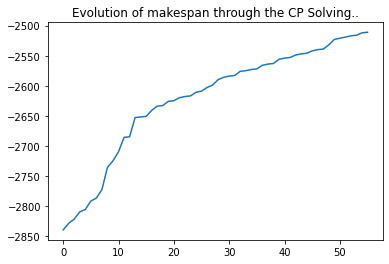

In [18]:
import matplotlib.pyplot as plt
plt.title("Evolution of makespan through the CP Solving..")
plt.plot([x[1] for x in results_storage.list_solution_fits])

# Bonus experiment ...Local Search !

In [19]:
import numpy as np
from discrete_optimization.generic_tools.ls.hill_climber import HillClimber
from discrete_optimization.generic_tools.ls.simulated_annealing import TemperatureSchedulingFactor, SimulatedAnnealing
from discrete_optimization.generic_tools.ls.local_search import RestartHandlerLimit, ModeMutation
from discrete_optimization.rcpsp.mutations.mutation_rcpsp import PermutationMutationRCPSP, DeadlineMutationRCPSP
from discrete_optimization.generic_tools.mutations.mixed_mutation import BasicPortfolioMutation
from discrete_optimization.generic_tools.mutations.permutation_mutations import PermutationShuffleMutation, \
    PermutationPartialShuffleMutation, PermutationSwap, TwoOptMutation

def solve_using_ls(rcpsp_problem: RCPSPModel, 
                   dummy_solution: RCPSPSolution):
    mutations = [(PermutationMutationRCPSP, {"other_mutation": PermutationShuffleMutation}),
                 (PermutationMutationRCPSP, {"other_mutation": DeadlineMutationRCPSP}),
                 (PermutationMutationRCPSP, {"proportion": 0.2, "other_mutation": PermutationPartialShuffleMutation}),
                 (PermutationMutationRCPSP, {"nb_swap": 3, "other_mutation": PermutationSwap}),
                 (PermutationMutationRCPSP, {"other_mutation": TwoOptMutation})]
    list_mutation = [mutate[0].build(rcpsp_problem,
                                     dummy_solution,
                                     **mutate[1]) for mutate in mutations
                     if mutate[0] == PermutationMutationRCPSP]
    mixed_mutation = BasicPortfolioMutation(list_mutation,
                                            np.ones((len(list_mutation))))
    res = RestartHandlerLimit(nb_iteration_no_improvement=300,
                              cur_solution=dummy_solution,
                              cur_objective=model.evaluate(dummy_solution))
    ls = None
    ls_solver = "sa"
    if ls_solver == "sa":
        ls = SimulatedAnnealing(evaluator=rcpsp_problem,
                                mutator=mixed_mutation,
                                restart_handler=res,
                                temperature_handler=
                                TemperatureSchedulingFactor(temperature=3,
                                                            restart_handler=res,
                                                            coefficient=0.999),
                                mode_mutation=ModeMutation.MUTATE,
                                store_solution=False,
                                nb_solutions=10000)
    elif ls_solver == "hc":
        ls = HillClimber(evaluator=rcpsp_problem,
                         mutator=mixed_mutation,
                         restart_handler=res,
                         mode_mutation=ModeMutation.MUTATE,
                         store_solution=True,
                         nb_solutions=10000)
    result_sa = ls.solve(dummy_solution,
                         nb_iteration_max=200000,
                         max_time_seconds=100,
                         pickle_result=False)
    return result_sa

In [20]:
results_local_search = solve_using_ls(rcpsp_problem=model, dummy_solution=dummy_solution)

none
['rcpsp_permutation']
5  mutation available
ModeOptim.MAXIMIZATION ObjectiveHandling.SINGLE ['makespan'] [-1]
iter  0
new obj  -2893  better than  -2897
iter  1
new obj  -2847  better than  -2893
iter  3
new obj  -2553  better than  -2847
iter  5
new obj  -2529  better than  -2553
iter  12
new obj  -2518  better than  -2529
iter  13
new obj  -2492  better than  -2518
iter  14
new obj  -2485  better than  -2492
iter  33
new obj  -2462  better than  -2485
iter  43
new obj  -2425  better than  -2462
iter  119
new obj  -2415  better than  -2425
iter  772
new obj  -2409  better than  -2415
iter  1461
new obj  -2406  better than  -2409
iter  2438
new obj  -2399  better than  -2406
iter  2803
new obj  -2395  better than  -2399
iter  2820
new obj  -2391  better than  -2395
iter  3129
new obj  -2387  better than  -2391
iter  3162
new obj  -2383  better than  -2387
iter  4063
new obj  -2381  better than  -2383
iter  5644
new obj  -2378  better than  -2381


In [21]:
best_solution = results_local_search.get_best_solution()
now = datetime.datetime.now()    
path_export = export(best_solution, 
                     name_instance=name_instance, 
                     name_file="my_results_"+str(now)+".json",
                     method="local-search")

solution exported in /Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp/export_result/my_results_2022-04-06 17:51:12.446823.json


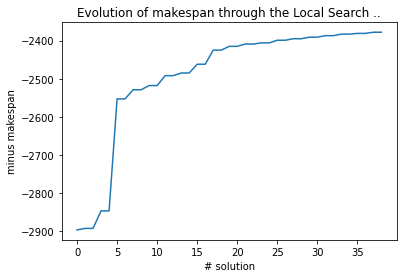

In [22]:
import matplotlib.pyplot as plt
plt.title("Evolution of makespan through the Local Search ..")
plt.ylabel("minus makespan")
plt.xlabel("# solution")
plt.plot([x[1] for x in results_local_search.list_solution_fits])